In [513]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

## Choose subject and file

In [527]:
task = 'listen'
period = 'pre'  
subjects_to_process = ['17']
#bad_ch_sub =  ['FC2', 'AF4', 'AF8', 'Fp2', 'F8','Iz', 'O1', 'PO7', 'PO3', 'P5', 'P7', 'P9', 'POz', 'Pz', 'CPz','Fpz', 'Oz']
bad_ch_sub = ['PO3', 'POz']

overwrite = False
keystroke_trigs = 'audio'
erp_begin = -0.5
erp_end = 0.5
erp_window = 'n05to05'
freq_high = 30


In [528]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = f"/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_{freq_high}Hz" #where the preprocessed files are

evokeds_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_ERP_data_{erp_window}_{freq_high}Hz'
epochs_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_{erp_window}_{freq_high}Hz'


with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)

ch_names_64 = ch_names_all[0:64]
ch_names_72 = ch_names_all[0:72]

"""ref_names = ['M1', 'M2']
eog_names = ['EOG1', 'EOG2']"""

downfreq = 128

In [529]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_{task}_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    all_electrodes = data['all_electrodes']
    events_sv = data['events']

    """  already_processed = []
    already_processed.append(subject_ID)"""


Opening eeg_listen_pre_17.mat


In [530]:
#making raw object from .mat data
info = mne.create_info(ch_names=ch_names_72, sfreq = 128, ch_types='misc')
raw = mne.io.RawArray(all_electrodes, info = info)

#define channel types
raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})

raw.set_montage('biosemi64')

Creating RawArray with float64 data, n_channels=72, n_times=85120
    Range : 0 ... 85119 =      0.000 ...   664.992 secs
Ready.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_14144/3214231580.py:6: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_14144/3214231580.py:7: RuntimeWarning: The unit for channel(s) LO1, LO2 has changed from NA to V.
  raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


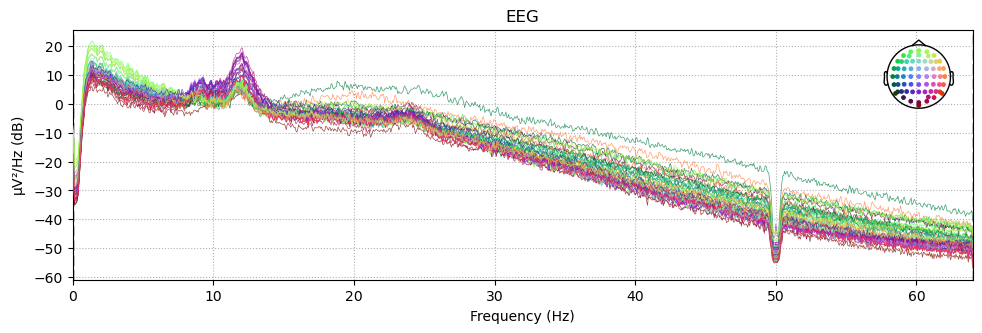

In [531]:
raw.info['bads'] = bad_ch_sub
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)


## ICA

Fitting ICA to data using 62 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_14144/1453259122.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 62 components
Fitting ICA took 16.3s.


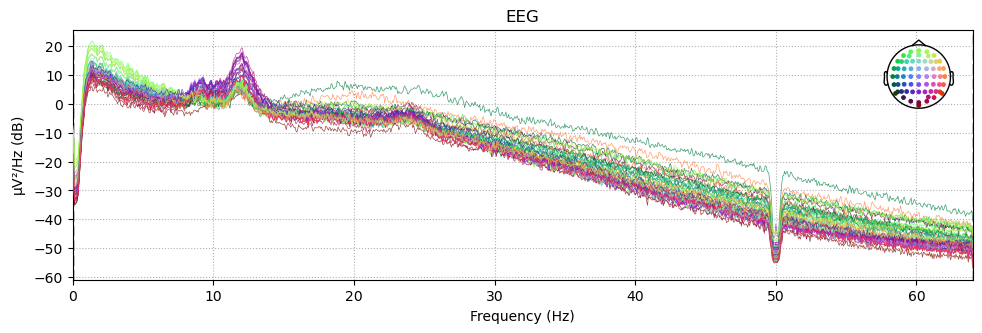

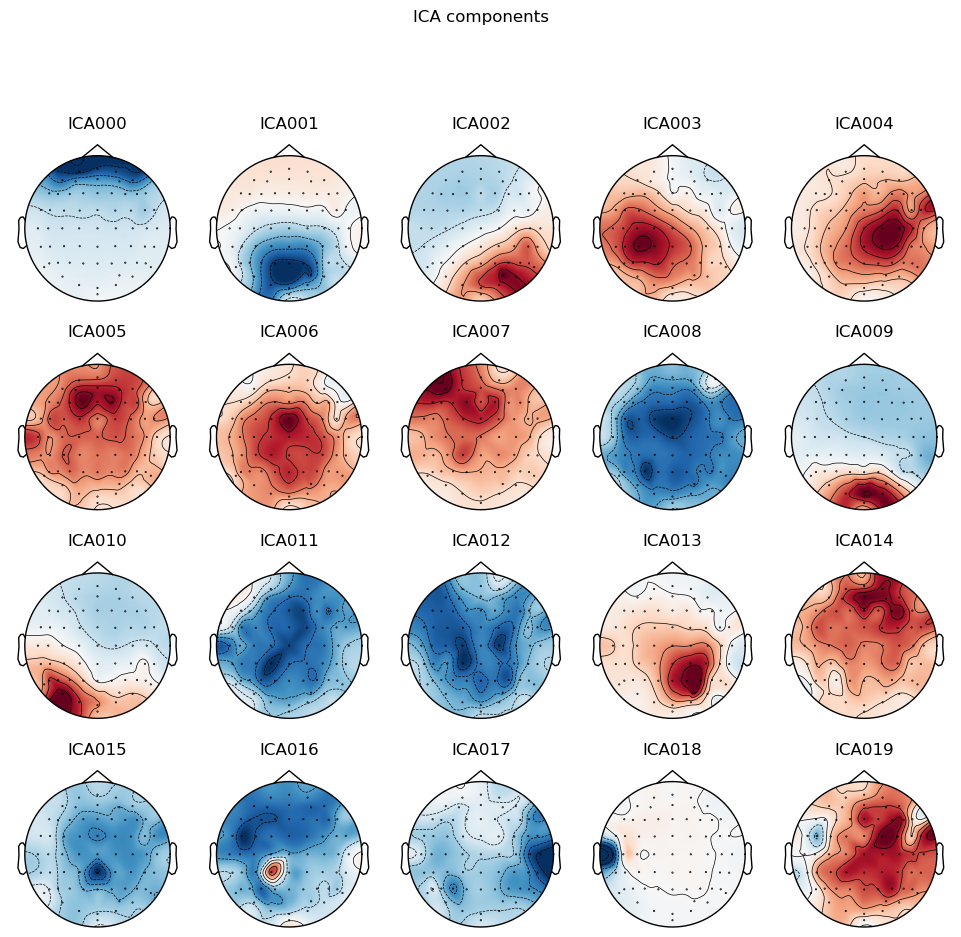

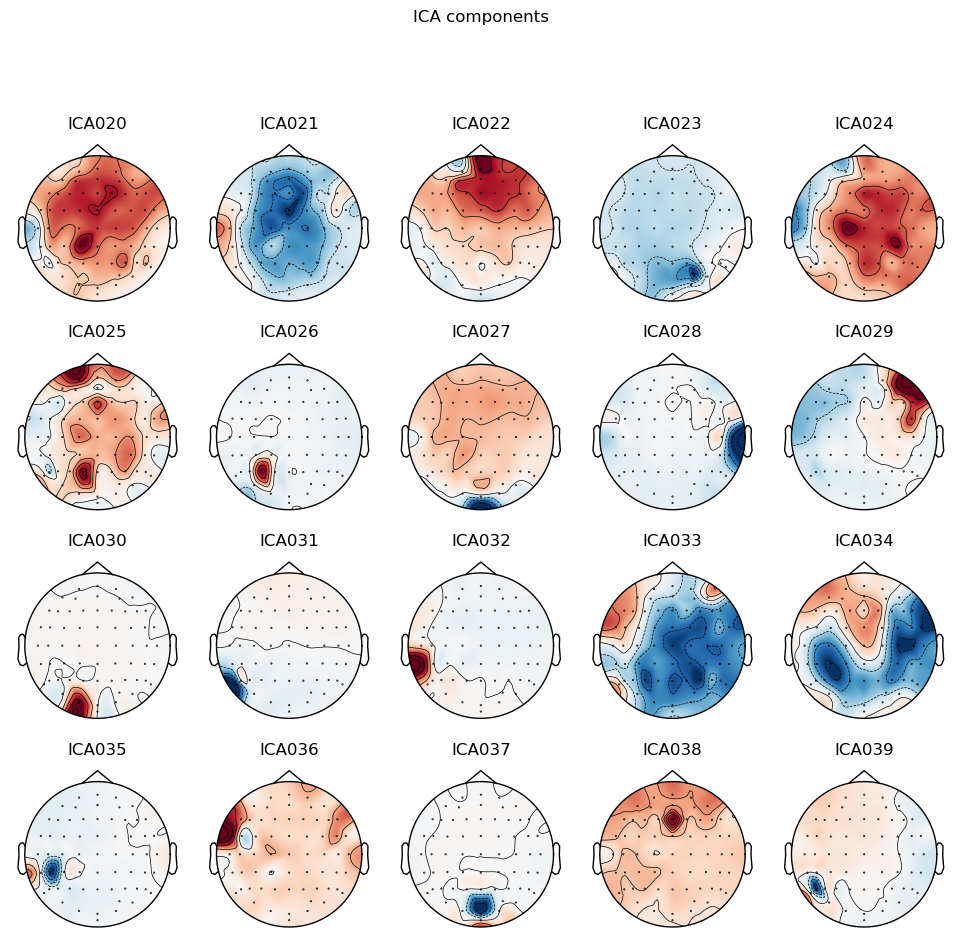

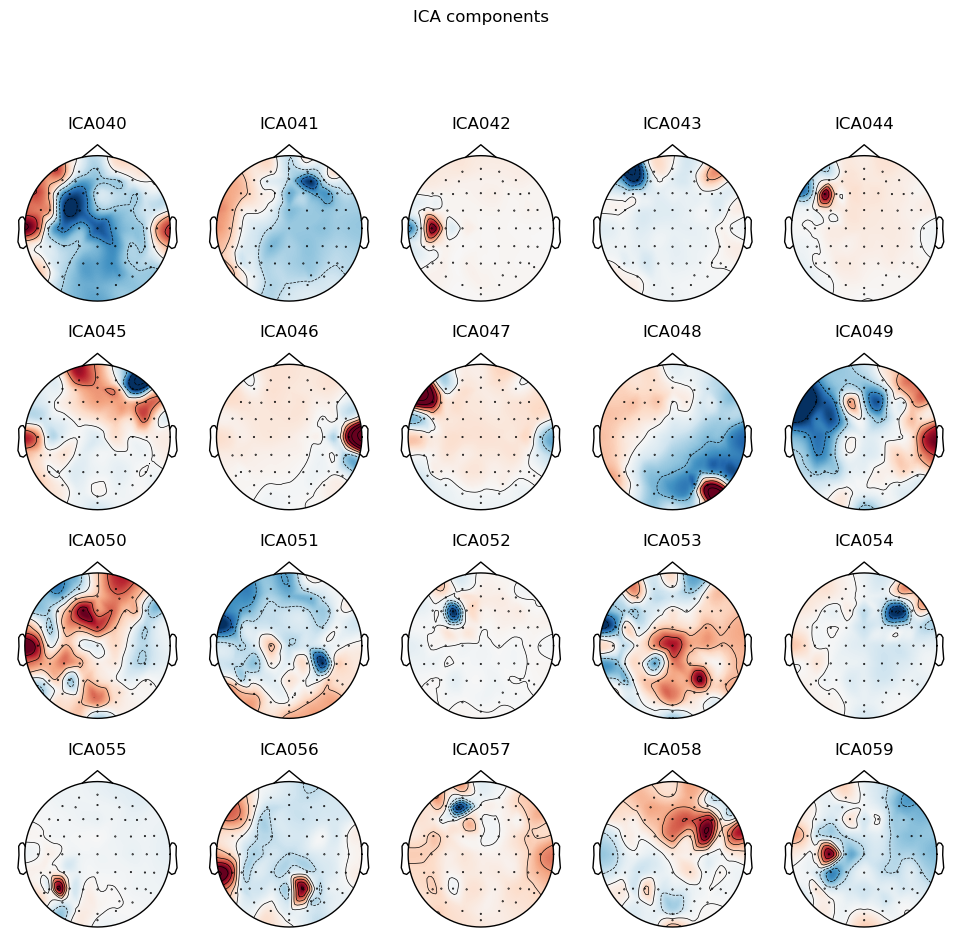

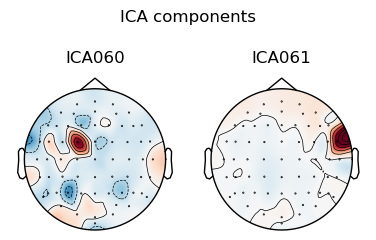

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 390x260.5 with 2 Axes>]

In [532]:
ica = ICA(max_iter='auto', random_state=97)

ica.fit(raw)

ica.plot_components()

#ICA components over time
#ica.plot_sources(raw)

In [533]:
#exclude components based on correlation to eog
eog_indices, eog_scores = ica.find_bads_eog(raw)
print('dropping ICA', eog_indices)
ica.exclude = eog_indices


#manually select components if eog not available

#ica.exclude = [0,1]


#reconstruct raw
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Using EOG channels: LO1, LO2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


dropping ICA [0, 29]
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

## PLOTS

All keystroke ERPs

Not setting metadata
328 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 328 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


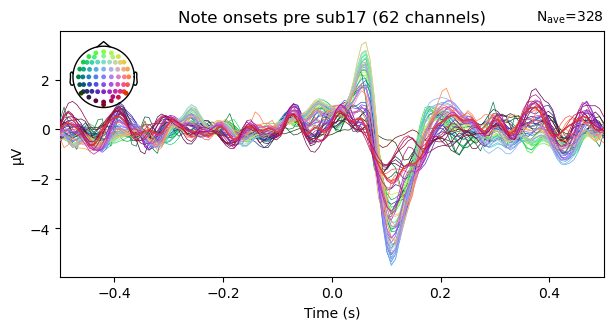

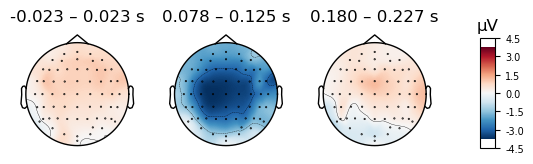

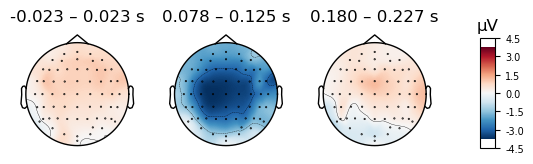

In [534]:
events_arr = make_raw_events(events_sv)
if keystroke_trigs == 'MIDI' and task == 'motor':
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==6])
else:
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=erp_begin, tmax=erp_end, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
evoked.plot(titles = f'Note onsets {period} sub{subject_ID}')

evoked.plot_topomap(times=[0,0.1, 0.2], average=0.05)

In [535]:
reject_criteria = dict(
    
    eeg=100e-6,  # 100 µV

)  # 100 µV
epochs.drop_bad(reject=reject_criteria)
print(epochs.drop_log)

    Rejecting  epoch based on EEG : ['P1', 'O1', 'Pz']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['P1', 'Pz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Pz', 'P2', 'PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P1', 'Pz', 'P2', 'PO4']
9 bad epochs dropped
((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('P1', 'O1', 'Pz'), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('F5',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('Pz',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('P1', 'Pz'), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), 

Not setting metadata
319 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


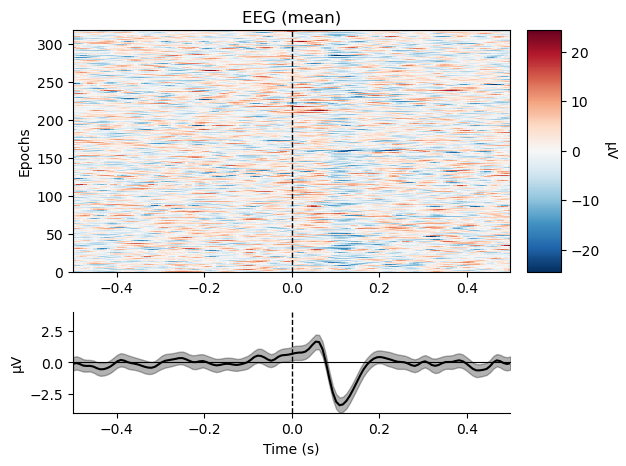

[<Figure size 640x480 with 3 Axes>]

In [536]:
mne.viz.plot_epochs_image(epochs, combine = 'mean')

In [537]:
evoked = evoked.copy().interpolate_bads(reset_bads = True)
epochs = epochs.copy().interpolate_bads(reset_bads = True)

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors


In [538]:
print(f'{evokeds_folder}/{task}_ERP_{period}_{subject_ID}.fif')

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_ERP_data_n05to05_30Hz/listen_ERP_pre_17.fif


In [539]:
overwrite = True

mne.write_evokeds(f'{evokeds_folder}/{task}_ERP_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
epochs.save(f'{epochs_folder}/{task}_epochs_{period}_{subject_ID}.fif', overwrite = overwrite)


Overwriting existing file.
Overwriting existing file.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_14144/3545096127.py:3: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_ERP_data_n05to05_30Hz/listen_ERP_pre_17.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds(f'{evokeds_folder}/{task}_ERP_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_14144/3545096127.py:4: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_17.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(f'{epochs_folder}/{task}_epochs_{period}_{subject_ID}.fif', overwrite = overwrite)
